In [35]:
# import EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [36]:
# load the dataset
df = pd.read_csv('customer_orders.csv')

In [37]:
# Make a copy of the dataset
df_copy = df.copy()

In [38]:
# Display the first 5 rows of the dataset
print(df_copy.head())

    Customer Name                    Email Total Spent  Total Orders  \
0  Melissa Zammit                      NaN   $2,995.82            64   
1   Taemyn Hollis                      NaN   $2,902.17            21   
2  Paul Kelsey Jr                      NaN   $2,041.59           170   
3  robert andrade                      NaN     $619.83            38   
4       Alex Zoll  alexa.zolli92@gmail.com     $108.96             2   

  Average Purchase Average Monthly Spend  Average Monthly Orders  \
0           $46.81                $65.13                       1   
1          $138.20                $54.76                       0   
2           $12.01                $22.44                       1   
3           $16.31                $13.77                       0   
4           $54.48                 $9.91                       0   

   Last Ordered Customer Since   Customer Lifetime  
0  Jun 08, 2023   Apr 06, 2020   3 yrs 9 mos 9 dys  
1  May 19, 2023   Sep 03, 2019  4 yrs 4 mos 11 dys  

In [39]:
# Drop Email column
df_copy = df_copy.drop('Email', axis=1)

In [40]:
# Display the first 5 rows of the dataset
print(df_copy.head())

    Customer Name Total Spent  Total Orders Average Purchase  \
0  Melissa Zammit   $2,995.82            64           $46.81   
1   Taemyn Hollis   $2,902.17            21          $138.20   
2  Paul Kelsey Jr   $2,041.59           170           $12.01   
3  robert andrade     $619.83            38           $16.31   
4       Alex Zoll     $108.96             2           $54.48   

  Average Monthly Spend  Average Monthly Orders  Last Ordered Customer Since  \
0                $65.13                       1  Jun 08, 2023   Apr 06, 2020   
1                $54.76                       0  May 19, 2023   Sep 03, 2019   
2                $22.44                       1  Dec 08, 2021   Jun 22, 2016   
3                $13.77                       0  Dec 23, 2023   May 01, 2020   
4                 $9.91                       0  Mar 02, 2023   Mar 06, 2021   

    Customer Lifetime  
0   3 yrs 9 mos 9 dys  
1  4 yrs 4 mos 11 dys  
2  7 yrs 6 mos 23 dys  
3  3 yrs 8 mos 13 dys  
4       10 mos

In [41]:
# Clean up column names
df_copy.columns = df_copy.columns.str.replace(' ', '_').str.lower()
print(df_copy.columns)

Index(['customer_name', 'total_spent', 'total_orders', 'average_purchase',
       'average_monthly_spend', 'average_monthly_orders', 'last_ordered',
       'customer_since', 'customer_lifetime'],
      dtype='object')


In [42]:
# List of numeric columns containing monetary values
numeric_columns = ['total_spent', 'total_orders', 'average_purchase', 
                   'average_monthly_spend', 'average_monthly_orders']

# Iterate over each numeric column
for col in numeric_columns:
    # Remove commas and the dollar sign ($) and convert to float
    df_copy[col] = df_copy[col].replace(r'[\$,]', '', regex=True).astype(float)

# Display the first 5 rows of the dataset
print(df_copy.head())


    customer_name  total_spent  total_orders  average_purchase  \
0  Melissa Zammit      2995.82          64.0             46.81   
1   Taemyn Hollis      2902.17          21.0            138.20   
2  Paul Kelsey Jr      2041.59         170.0             12.01   
3  robert andrade       619.83          38.0             16.31   
4       Alex Zoll       108.96           2.0             54.48   

   average_monthly_spend  average_monthly_orders  last_ordered customer_since  \
0                  65.13                     1.0  Jun 08, 2023   Apr 06, 2020   
1                  54.76                     0.0  May 19, 2023   Sep 03, 2019   
2                  22.44                     1.0  Dec 08, 2021   Jun 22, 2016   
3                  13.77                     0.0  Dec 23, 2023   May 01, 2020   
4                   9.91                     0.0  Mar 02, 2023   Mar 06, 2021   

    customer_lifetime  
0   3 yrs 9 mos 9 dys  
1  4 yrs 4 mos 11 dys  
2  7 yrs 6 mos 23 dys  
3  3 yrs 8 mos 13 dy

In [43]:
# Convert both date columns to datetime
df_copy['customer_since'] = pd.to_datetime(df_copy['customer_since'])
df_copy['last_ordered'] = pd.to_datetime(df_copy['last_ordered'])

# Display the first 5 rows of the dataset
print(df_copy.head())

    customer_name  total_spent  total_orders  average_purchase  \
0  Melissa Zammit      2995.82          64.0             46.81   
1   Taemyn Hollis      2902.17          21.0            138.20   
2  Paul Kelsey Jr      2041.59         170.0             12.01   
3  robert andrade       619.83          38.0             16.31   
4       Alex Zoll       108.96           2.0             54.48   

   average_monthly_spend  average_monthly_orders last_ordered customer_since  \
0                  65.13                     1.0   2023-06-08     2020-04-06   
1                  54.76                     0.0   2023-05-19     2019-09-03   
2                  22.44                     1.0   2021-12-08     2016-06-22   
3                  13.77                     0.0   2023-12-23     2020-05-01   
4                   9.91                     0.0   2023-03-02     2021-03-06   

    customer_lifetime  
0   3 yrs 9 mos 9 dys  
1  4 yrs 4 mos 11 dys  
2  7 yrs 6 mos 23 dys  
3  3 yrs 8 mos 13 dys  
4 

In [44]:
# Check for missing values
print(df_copy.isnull().sum())

customer_name             0
total_spent               0
total_orders              0
average_purchase          0
average_monthly_spend     0
average_monthly_orders    0
last_ordered              0
customer_since            0
customer_lifetime         0
dtype: int64


In [45]:
# Calculate customer tenure (the time between customer_since and last_ordered)
df_copy['customer_tenure'] = df_copy['last_ordered'] - df_copy['customer_since']

# Calculate recency (time since the last order)
today = pd.to_datetime('today')
df_copy['recency'] = today - df_copy['last_ordered']

# Display the first few rows to verify
print(df_copy[['customer_tenure', 'recency']].head())

  customer_tenure                  recency
0       1158 days 256 days 22:28:20.031968
1       1354 days 276 days 22:28:20.031968
2       1995 days 803 days 22:28:20.031968
3       1331 days  58 days 22:28:20.031968
4        726 days 354 days 22:28:20.031968


In [46]:
# Display first 5 rows of the dataset
print(df_copy.head())

    customer_name  total_spent  total_orders  average_purchase  \
0  Melissa Zammit      2995.82          64.0             46.81   
1   Taemyn Hollis      2902.17          21.0            138.20   
2  Paul Kelsey Jr      2041.59         170.0             12.01   
3  robert andrade       619.83          38.0             16.31   
4       Alex Zoll       108.96           2.0             54.48   

   average_monthly_spend  average_monthly_orders last_ordered customer_since  \
0                  65.13                     1.0   2023-06-08     2020-04-06   
1                  54.76                     0.0   2023-05-19     2019-09-03   
2                  22.44                     1.0   2021-12-08     2016-06-22   
3                  13.77                     0.0   2023-12-23     2020-05-01   
4                   9.91                     0.0   2023-03-02     2021-03-06   

    customer_lifetime customer_tenure                  recency  
0   3 yrs 9 mos 9 dys       1158 days 256 days 22:28:20.0

In [47]:
# Calculate historical CLV
historical_clv = df_copy.groupby('customer_name')['total_spent'].sum()

# Display the historical CLV for each customer
print(historical_clv)

customer_name
. laymarisol          7.51
A Allen              45.69
A.C. Bendle         183.65
A.J. Holley          18.91
AF AF                19.63
                     ...  
yolanda rosales     154.13
yvette alexander    100.65
zach dillard         16.41
zahara williams       9.46
Érica Sanchez        29.69
Name: total_spent, Length: 4765, dtype: float64


In [48]:
# Display summary statistics of the entire dataset
print(df_copy.describe())

       total_spent  total_orders  average_purchase  average_monthly_spend  \
count  5025.000000   5025.000000       5025.000000            5025.000000   
mean     91.954762      3.324577         34.852736               4.664764   
min       4.450000      1.000000          4.450000               0.050000   
25%      19.800000      1.000000         14.470000               0.590000   
50%      35.510000      1.000000         22.950000               1.490000   
75%      88.060000      2.000000         38.450000               4.140000   
max    2995.820000    220.000000        911.020000             529.280000   
std     192.981239      8.339908         41.090587              13.412739   

       average_monthly_orders                   last_ordered  \
count             5025.000000                           5025   
mean                 0.034030  2021-07-18 13:33:51.044776192   
min                  0.000000            2014-12-16 00:00:00   
25%                  0.000000            2020-06-2

In [49]:
# Print shape of the dataset
print(df_copy.shape)

(5025, 11)


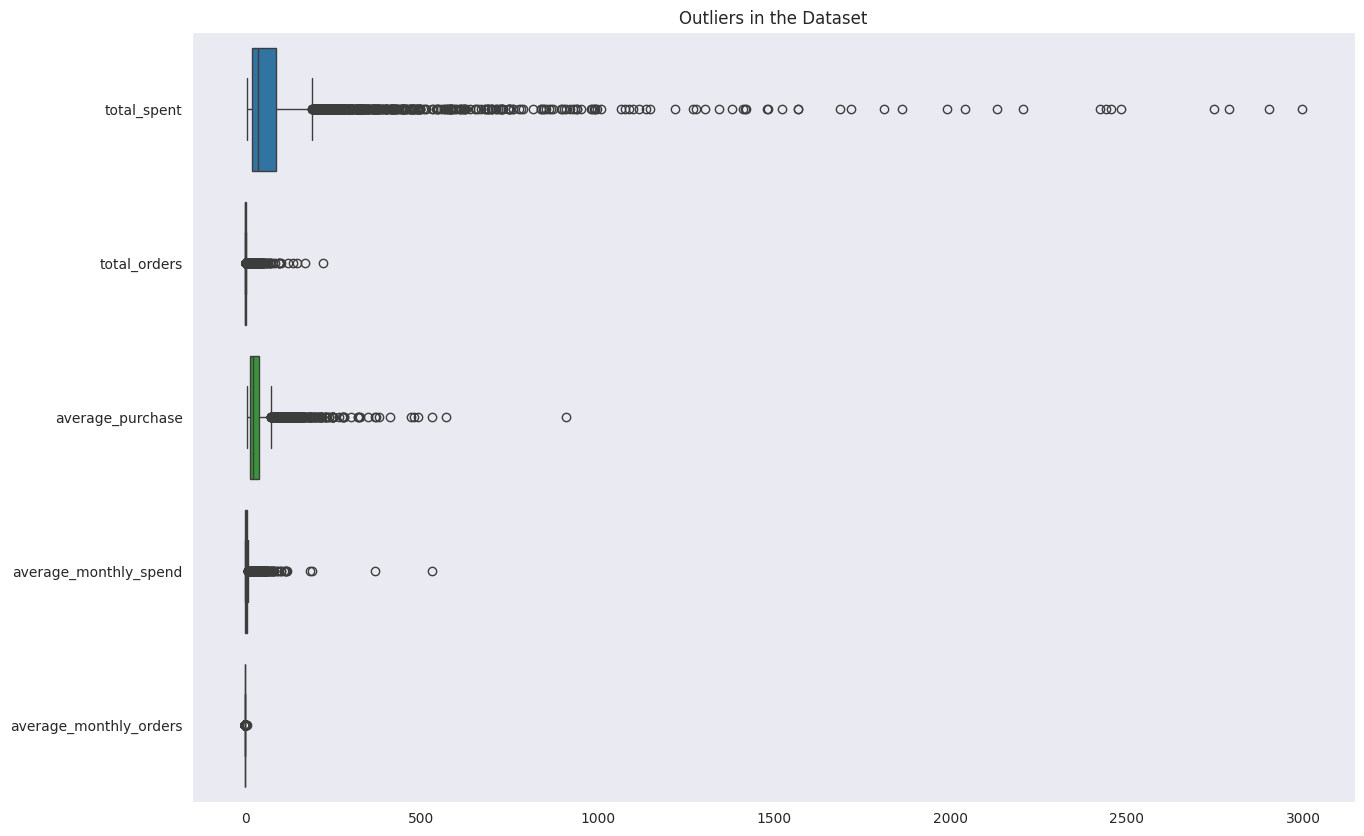

   total_spent  total_orders  average_purchase  average_monthly_spend  \
0    15.047397      7.275311          0.290998               4.508045   
1    14.562116      2.119379          2.515108               3.734900   
2    10.102719     19.985283         -0.555912               1.325250   
3     2.735371      4.157770         -0.451265               0.678850   
4     0.088119     -0.158824          0.477658               0.391064   

   average_monthly_orders  
0                4.445787  
1               -0.156619  
2                4.445787  
3               -0.156619  
4               -0.156619  
      customer_name  total_spent  total_orders  average_purchase  \
0    Melissa Zammit      2995.82          64.0             46.81   
1     Taemyn Hollis      2902.17          21.0            138.20   
2    Paul Kelsey Jr      2041.59         170.0             12.01   
3    robert andrade       619.83          38.0             16.31   
14  Evan Lefelstein       618.27          96.0       

In [50]:
# check each numerical feature for outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_copy, orient='h')
plt.title('Outliers in the Dataset')
plt.show()

# Calculate the z-scores of each feature
z_scores = (df_copy[numeric_columns] - df_copy[numeric_columns].mean()) / df_copy[numeric_columns].std()

# Display the first few rows of the z-scores
print(z_scores.head())

# Find the number of rows where the z-scores are greater than 3 or less than -3
outliers = df_copy[(z_scores > 3).any(axis=1) | (z_scores < -3).any(axis=1)]

# Display the first few rows of the dataset
print(outliers.head())

In [51]:
# Identify the top 50 customers by lifetime value
top_50_customers = historical_clv.sort_values(ascending=False).head(50)

# Display the top 50 customers by lifetime value
print(top_50_customers)

customer_name
Robin Casper           3088.47
Melissa Zammit         2995.82
Taemyn Hollis          2902.17
Justin Filpovich       2788.12
Larry Ulanski          2747.41
Angeles Tenorio        2455.11
Matt Mrozek            2440.77
Brian Boyle            2424.23
Maggie Headley         2206.26
Beatrice Mullooly      2132.72
Paul Kelsey Jr         2041.59
Morgan Gabrielson      1988.81
Dion Glass             1939.50
Laura Witt             1863.01
cristal tucker         1811.06
Robert Martinez        1685.87
Andrew Schmidt         1567.09
Angelica Fierro        1566.62
John Wieser            1522.04
Deanna Cozzi           1482.26
Romina Flojo           1478.60
Christina Gatsoudis    1420.15
Dan Pratscher          1417.01
Win Lim                1410.84
Chad Brody             1379.92
Benjamin Milligan      1379.58
Joanie Vernasco        1369.99
Joe Carroll            1344.58
Melissa Baglio         1303.36
Kathleen Kazimir       1277.15
Carlos Garcia          1270.74
Alexis Sennstrom       11

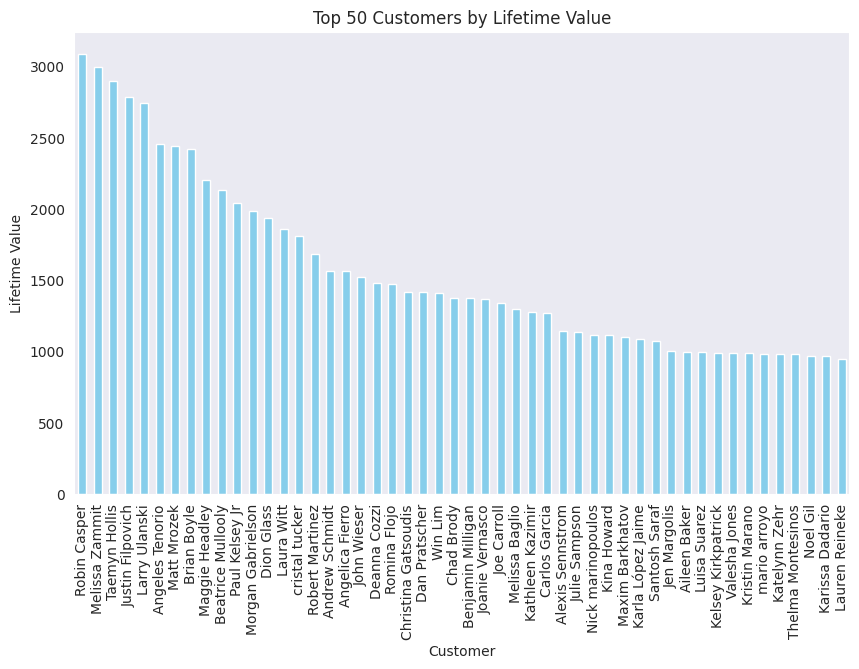

In [52]:
# Plot the top 50 customers by lifetime value
plt.figure(figsize=(10, 6))
top_50_customers.plot(kind='bar', color='skyblue')
plt.title('Top 50 Customers by Lifetime Value')
plt.ylabel('Lifetime Value')
plt.xlabel('Customer')
plt.show()

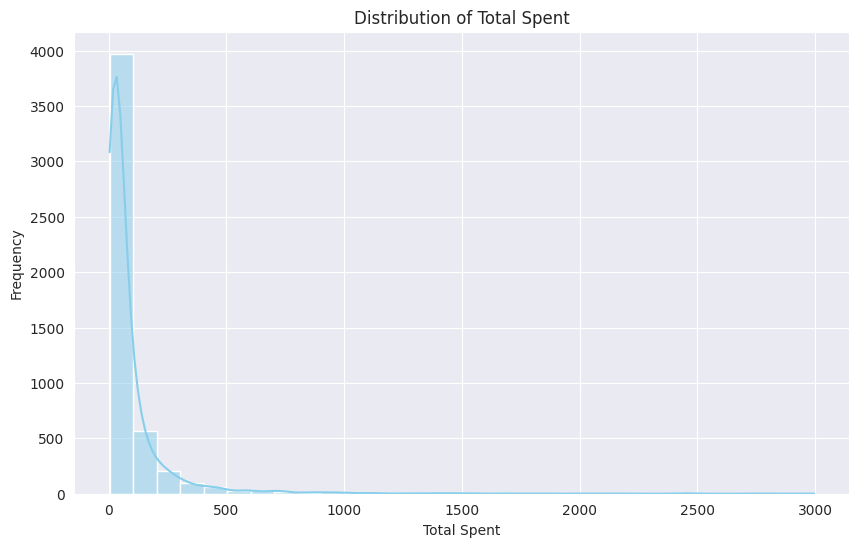

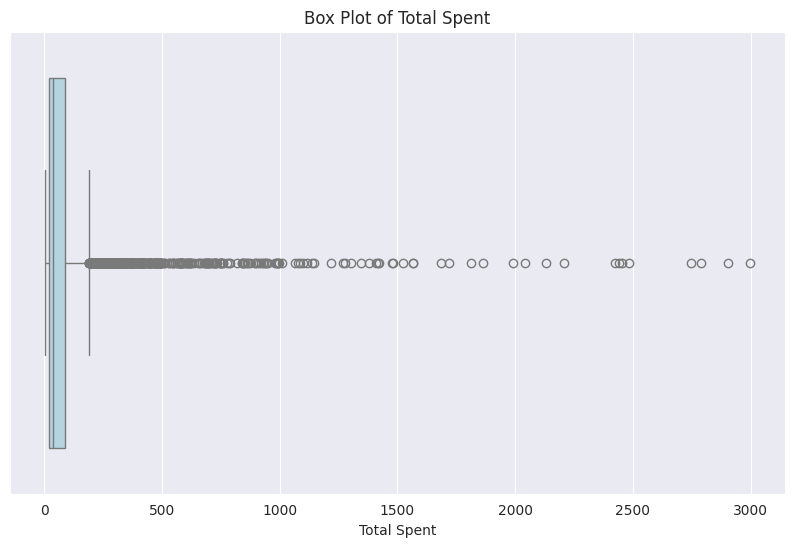

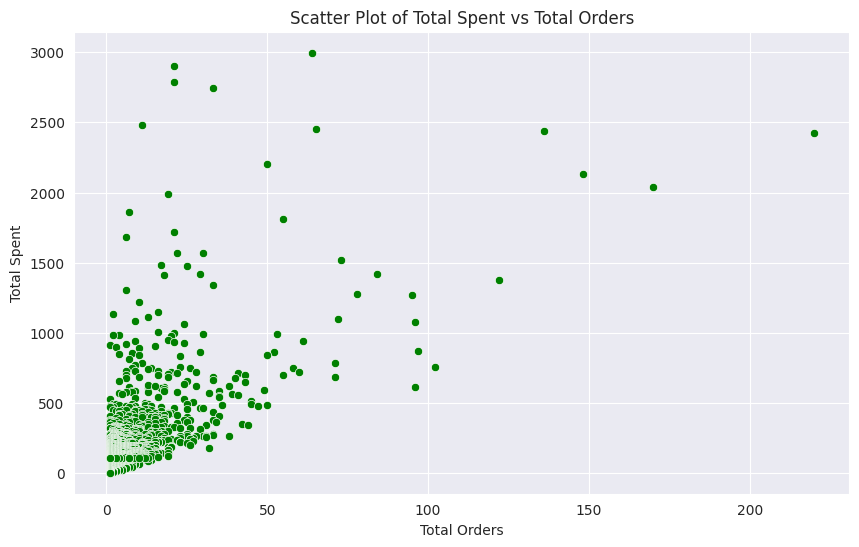

In [53]:
# Set the style for seaborn to darkgrid
sns.set_style("darkgrid")

# Histogram of total_spent
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['total_spent'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.show()

# Box plot of total_spent
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_copy['total_spent'], color='lightblue')
plt.title('Box Plot of Total Spent')
plt.xlabel('Total Spent')
plt.show()

# Scatter plot of total_spent vs total_orders
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_orders', y='total_spent', data=df_copy, color='green')
plt.title('Scatter Plot of Total Spent vs Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Total Spent')
plt.show()

                        total_spent  total_orders  average_purchase  \
total_spent                1.000000      0.691868          0.325042   
total_orders               0.691868      1.000000         -0.069798   
average_purchase           0.325042     -0.069798          1.000000   
average_monthly_spend      0.441188      0.202959          0.441115   
average_monthly_orders     0.320814      0.512255         -0.014493   

                        average_monthly_spend  average_monthly_orders  
total_spent                          0.441188                0.320814  
total_orders                         0.202959                0.512255  
average_purchase                     0.441115               -0.014493  
average_monthly_spend                1.000000                0.418209  
average_monthly_orders               0.418209                1.000000  


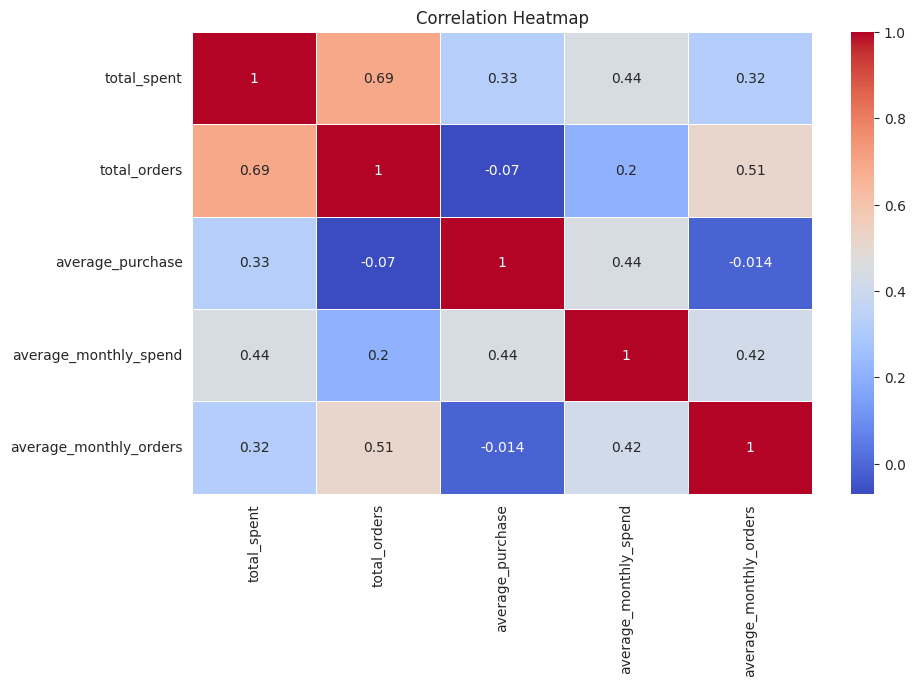

In [54]:
# Exclude non-numeric columns before correlation analysis
numeric_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns
correlation = df_copy[numeric_columns].corr()

# Display the correlation matrix
print(correlation)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Total Spent vs. Total Orders: There is a strong positive correlation (0.691868) between the total amount spent by customers and the total number of orders they've made. This suggests that customers who spend more tend to place more orders, which is intuitive.

Total Spent vs. Average Purchase: There is a moderate positive correlation (0.325042) between the total amount spent and the average purchase amount. This indicates that customers who spend more tend to have higher average purchase amounts.

Total Spent vs. Average Monthly Spend: There is a moderate positive correlation (0.441188) between the total amount spent and the average monthly spend. This suggests that customers who have spent more in total also tend to have higher average monthly spending.

Total Orders vs. Average Monthly Orders: There is a moderate positive correlation (0.512255) between the total number of orders and the average monthly number of orders. This indicates that customers who place more orders in total also tend to place more orders on average per month.

In [55]:
df_copy['recency'].dt.days.describe()

count    5025.000000
mean      945.434826
std       777.019931
min        31.000000
25%       297.000000
50%       761.000000
75%      1336.000000
max      3352.000000
Name: recency, dtype: float64

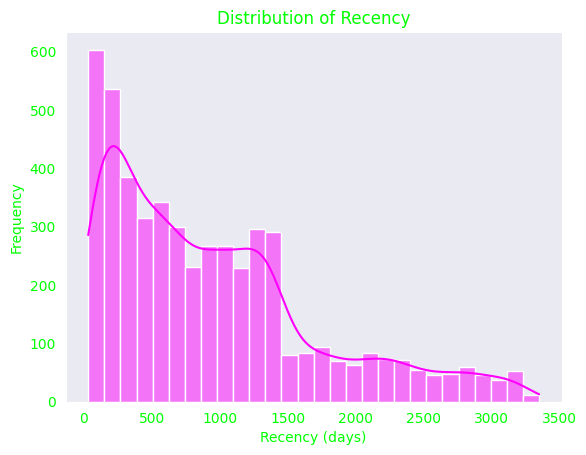

In [56]:
# Set the style for seaborn to dark
sns.set_style("dark")
sns.histplot(data=df_copy, x=df_copy['recency'].dt.days, kde=True, color='magenta')

# Set the title, x-label, and y-label with neon colors
plt.title('Distribution of Recency', color='lime')
plt.xlabel('Recency (days)', color='lime')
plt.ylabel('Frequency', color='lime')

# Customize ticks color
plt.xticks(color='lime')
plt.yticks(color='lime')

# Show the plot
plt.show()

In [57]:
# Convert recency to number of days
df_copy['recency_days'] = df_copy['recency'].dt.days

# Filter customers who haven't ordered in the last 365 days
inactive_customers = df_copy[df_copy['recency_days'] > 365]

# Display the inactive customers
print(inactive_customers)

                                    customer_name  total_spent  total_orders  \
2                                  Paul Kelsey Jr      2041.59         170.0   
5                                     Jovan Dupor       108.92           3.0   
7     ccpa_redacted_1042196 ccpa_redacted_1042196       108.69           6.0   
9                                Madeline O'Neill       108.37           2.0   
11                                Bianca Santiago       108.17           1.0   
...                                           ...          ...           ...   
5020                             Renee Vandenberg       109.46           1.0   
5021                                 Joelle Lantz       109.32           7.0   
5022                             Alexandra Marcus       109.12           3.0   
5023                                 Chris harper       109.01           1.0   
5024                                  Nat Winters       108.97           1.0   

      average_purchase  average_monthly

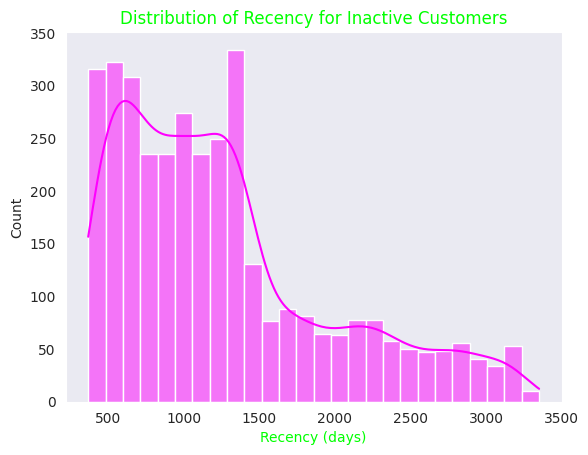

In [58]:
# Plot a histogram of the recency of inactive customers
sns.histplot(data=inactive_customers, x="recency_days", kde=True, color='magenta')
plt.xlabel('Recency (days)', color='lime')
plt.title('Distribution of Recency for Inactive Customers', color='lime')
plt.show()

/tmp/ipykernel_5007/1492535118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_customers['recency_years'] = inactive_customers['recency_days'] // 365


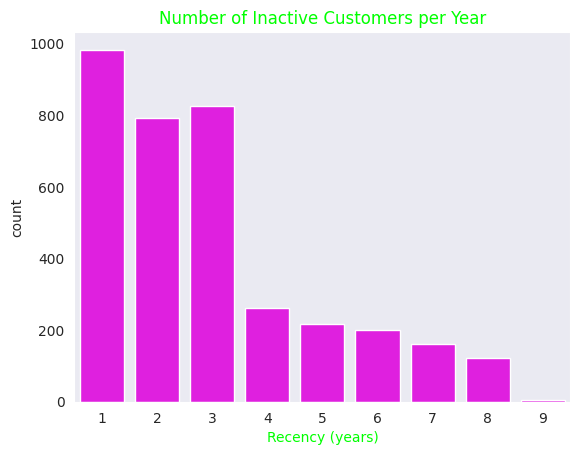

In [59]:
# Calculate the number of years of inactivity
inactive_customers['recency_years'] = inactive_customers['recency_days'] // 365

# Plot a bar plot of the number of inactive customers per year
sns.countplot(data=inactive_customers, x="recency_years", color='magenta')
plt.xlabel('Recency (years)', color='lime')
plt.title('Number of Inactive Customers per Year', color='lime')
plt.show()

In [60]:
# Define churned customers as those who haven't ordered in the last 365 days
churned_customers = df_copy[df_copy['recency_days'] > 365]

# Calculate churn rate
churn_rate = len(churned_customers) / len(df_copy)

print(f"The customer churn rate is: {churn_rate * 100:.2f}%")

The customer churn rate is: 70.95%


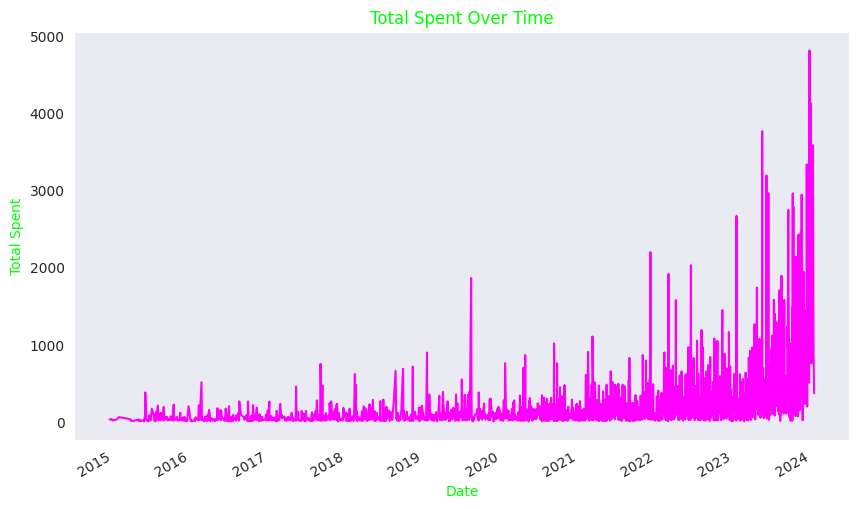

In [61]:
# Ensure your date column is in datetime format
df_copy['last_ordered'] = pd.to_datetime(df_copy['last_ordered'])

# Sort the data by date
df_sorted = df_copy.sort_values('last_ordered')

# Group by date and calculate total spent
total_spent_per_date = df_sorted.groupby('last_ordered')['total_spent'].sum()

# Plot the total spent over time
plt.figure(figsize=(10,6))
total_spent_per_date.plot(kind='line', color='magenta')
plt.title('Total Spent Over Time', color='lime')
plt.xlabel('Date', color='lime')
plt.ylabel('Total Spent', color='lime')
plt.show()

In [62]:
from sklearn.preprocessing import StandardScaler

# Select columns
df_cluster = df_copy[['total_spent', 'total_orders', 'recency_days']]

# Scale the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

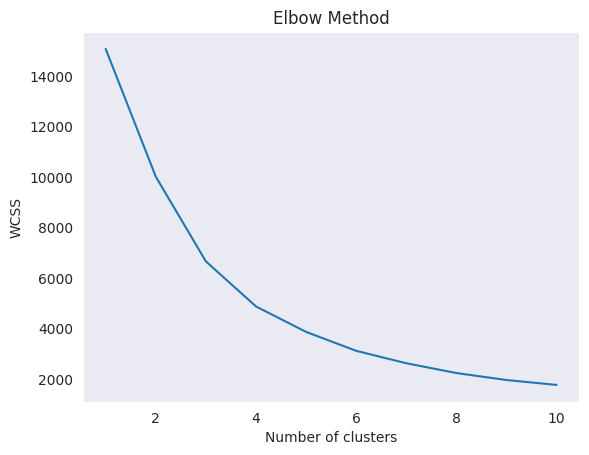

In [63]:
from sklearn.cluster import KMeans

# Calculate WCSS for different number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [64]:
# Convert timedelta to a number of days
df_copy['customer_tenure_days'] = df_copy['customer_tenure'].dt.days

# Build the model with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(df_cluster_scaled)

# Assign the cluster labels back to the original DataFrame
df_copy['cluster_label'] = cluster_labels

# Select only numeric columns
numeric_cols = df_copy.select_dtypes(include=[np.number])

# Group by cluster label and calculate average values of numeric columns
df_clusters = numeric_cols.groupby(df_copy['cluster_label']).mean()

# Display the clusters
print(df_clusters)

               total_spent  total_orders  average_purchase  \
cluster_label                                                
0                65.314151      2.282772         34.078911   
1                45.828197      1.544279         33.564764   
2              1725.346400     84.480000         38.451200   
3               557.334378     19.642570         52.450602   

               average_monthly_spend  average_monthly_orders  \
cluster_label                                                  
0                           5.079825                0.030899   
1                           0.747072                0.000000   
2                          38.086000                1.160000   
3                          20.308474                0.172691   

                           customer_tenure                      recency  \
cluster_label                                                             
0              974 days 03:45:10.112359552  537 days 06:29:40.930844408   
1              36

total_spent: This is the average total amount that customers in each cluster have spent. For example, customers in cluster 0 have spent an average of 65.31 units of currency (dollars, euros, etc.), while customers in cluster 2 have spent an average of 1725.35 units of currency.

total_orders: This is the average total number of orders that customers in each cluster have made. For example, customers in cluster 0 have made an average of 2.28 orders, while customers in cluster 2 have made an average of 84.48 orders.

average_purchase: This is the average amount spent per purchase by customers in each cluster. For example, customers in cluster 0 spend an average of 34.08 units of currency per purchase, while customers in cluster 3 spend an average of 52.45 units of currency per purchase.

average_monthly_spend: This is the average amount that customers in each cluster spend per month. For example, customers in cluster 0 spend an average of 5.08 units of currency per month, while customers in cluster 2 spend an average of 38.09 units of currency per month.

average_monthly_orders: This is the average number of orders that customers in each cluster make per month. For example, customers in cluster 0 make an average of 0.03 orders per month, while customers in cluster 2 make an average of 1.16 orders per month.

customer_tenure_days: This is the average number of days since the customer's first purchase in each cluster. For example, customers in cluster 0 have been customers for an average of 974.16 days, while customers in cluster 2 have been customers for an average of 1978.44 days.

recency_days: This is the average number of days since the customer's last purchase in each cluster. For example, customers in cluster 0 made their last purchase an average of 530.33 days ago, while customers in cluster 2 made their last purchase an average of 259.36 days ago.



Based on the characteristics of each cluster, here are some potential strategies:

1. **Cluster 0 (New Customers)**: These customers are relatively new and haven't made many purchases yet. Strategies could include:
   - **Welcome offers**: Provide special discounts or offers to encourage them to make their next purchase.
   - **Onboarding emails**: Send them useful information about your products or services to help them get started.
   - **Product recommendations**: Based on their initial purchases, recommend other products they might be interested in.

2. **Cluster 1 (Inactive Customers)**: These customers made a few purchases a long time ago but haven't been active recently. Strategies could include:
   - **Re-engagement campaigns**: Send them personalized emails reminding them of your products or services, and offer special discounts to encourage them to return.
   - **Survey**: Ask them for feedback to understand why they haven't been active. This can provide valuable insights to improve your offerings.

3. **Cluster 2 (Loyal Customers)**: These customers make regular purchases and have been customers for a long time. Strategies could include:
   - **Loyalty programs**: Reward them for their loyalty with points, discounts, or special perks.
   - **Exclusive offers**: Give them early access to new products or exclusive deals.
   - **Personalized communication**: Since you have a lot of data about these customers, use it to personalize your communication and offers.

4. **Cluster 3 (High-Value Infrequent Customers)**: These customers make infrequent but high-value purchases. Strategies could include:
   - **Personalized offers**: Based on their purchase history, send them personalized offers to encourage repeat purchases.
   - **Upselling or cross-selling**: Since they make high-value purchases, they might be interested in premium products or services. Offer them upgrades or related products to increase their order value.
   - **Engagement content**: Keep them engaged with relevant content (blogs, tutorials, webinars) related to the products they purchased.

Remember, these are just suggestions. The best strategies will depend on the specifics of your business and customers. Always test different strategies and measure their effectiveness to find what works best for your business.

Here are some customer retention strategies tailored to each cluster:

1. **Cluster 0 (New Customers)**: These customers are relatively new and haven't made many purchases yet. Retention strategies could include:
   - **Customer Education**: Provide resources or tutorials to help them understand and get the most out of your product or service.
   - **Early Engagement**: Engage them early with excellent customer service and support to build a strong relationship.
   - **Follow-up Communication**: Regularly check in with personalized messages or offers to keep your brand at the top of their mind.

2. **Cluster 1 (Inactive Customers)**: These customers made a few purchases a long time ago but haven't been active recently. Retention strategies could include:
   - **Win-back Campaigns**: Implement campaigns specifically designed to win back lapsed customers. This could involve special offers or highlighting new features or products since they last shopped.
   - **Feedback Loop**: Reach out to them to understand why they stopped purchasing. Their feedback can provide valuable insights to prevent other customers from becoming inactive.

3. **Cluster 2 (Loyal Customers)**: These customers make regular purchases and have been customers for a long time. Retention strategies could include:
   - **Loyalty Programs**: Implement a loyalty program that rewards them for their repeat business. This could involve discounts, exclusive offers, or early access to new products.
   - **Customer Appreciation**: Show appreciation for their loyalty through personalized thank you messages, gifts, or special recognition.

4. **Cluster 3 (High-Value Infrequent Customers)**: These customers make infrequent but high-value purchases. Retention strategies could include:
   - **Personalized Communication**: Use the data you have about their purchases to personalize your communication and make them feel valued.
   - **Exclusive Offers**: Provide exclusive offers or early access to new products or services that match their purchasing habits.
   - **Outstanding Customer Service**: High-value customers expect high-quality service. Ensure they have a dedicated point of contact or priority support to keep them satisfied.

Remember, the key to successful customer retention is understanding your customers' needs and meeting or exceeding those expectations. Always measure the success of your strategies and adjust as necessary based on your results.

In [65]:
# Display the cluster labels
print(df_copy[['customer_name', 'cluster_label']])

         customer_name  cluster_label
0       Melissa Zammit              2
1        Taemyn Hollis              2
2       Paul Kelsey Jr              2
3       robert andrade              3
4            Alex Zoll              0
...                ...            ...
5020  Renee Vandenberg              1
5021      Joelle Lantz              1
5022  Alexandra Marcus              0
5023      Chris harper              0
5024       Nat Winters              1

[5025 rows x 2 columns]


In [66]:
# Iterate over each cluster and count the number of customers in each cluster
for i in df_copy['cluster_label'].unique():
    segment = df_copy[df_copy['cluster_label'] == i]
    print(f'Cluster {i}: {len(segment)} customers')

Cluster 2: 25 customers
Cluster 3: 249 customers
Cluster 0: 3204 customers
Cluster 1: 1547 customers


In [67]:
# Save each cluster to a separate Excel sheet
with pd.ExcelWriter('customer_segments.xlsx') as writer:  
    for i in df_copy['cluster_label'].unique():
        segment = df_copy[df_copy['cluster_label'] == i]
        segment.to_excel(writer, sheet_name=f'Cluster_{i}')